In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import stats
import glob
from scipy.stats import ks_2samp, kstest
%matplotlib inline

In [2]:
def load_summary(filename):
    dtype=[('minr', 'f8'),
           ('maxr', 'f8'), 
           ('ca_ratio', 'f8'),
           ('ba_ratio', 'f8'),
           ('a', 'f8'),
           ('center', 'f8'),
           ('width', 'f8'),
           ('mu', 'f8')]
    summary = np.loadtxt(filename, dtype=dtype)    
    return summary

In [3]:
def load_experiment(input_path="../data/mstar_selected_summary/vmax_sorted/", fixed_number=False, full_data=False):
    files = glob.glob(input_path+"M31_group_*")
    group_id = []
    for f in files:
        i = int(f.split("_")[-5])
        if i not in group_id:
            group_id.append(i)
    print(group_id, len(group_id))

    n_groups = len(group_id)

    if fixed_number:
        n_iter = np.arange(5)
    else:
        n_iter = np.arange(11,16)
    
    fields = ['width','mu', 'a', 'ba_ratio', 'ca_ratio']
    M31_all = {}
    MW_all = {}
    if not full_data:
        for field in fields:
            M31_all[field] = np.ones(n_groups)
            MW_all[field] = np.ones(n_groups)
            M31_all[field+'_sigma'] = np.ones(n_groups)
            MW_all[field+'_sigma'] = np.ones(n_groups)
        
            M31_all[field+'_random'] = np.ones(n_groups)
            MW_all[field+'_random'] = np.ones(n_groups)
            M31_all[field+'_random_sigma'] = np.ones(n_groups)
            MW_all[field+'_random_sigma'] = np.ones(n_groups)
    else:
        for field in fields:
            M31_all[field] = np.empty((0))
            MW_all[field] = np.empty((0))
            M31_all[field+'_random'] = np.empty((0))
            MW_all[field+'_random'] = np.empty((0))
           

    for g in range(n_groups):

        MW_summary = {}
        M31_summary = {}
    
        for i in n_iter:
            if fixed_number:
                filename_MW = os.path.join(input_path,"MW_group_{}_nmax_{}_iter_{}.dat".format(group_id[g], 11, i))
                filename_M31 = os.path.join(input_path,"M31_group_{}_nmax_{}_iter_{}.dat".format(group_id[g],11, i))
            else:
                filename_MW = os.path.join(input_path,"MW_group_{}_nmax_{}_iter_{}.dat".format(group_id[g], i, 0))
                filename_M31 = os.path.join(input_path,"M31_group_{}_nmax_{}_iter_{}.dat".format(group_id[g], i, 0))

            MW_summary[i] = load_summary(filename_MW)
            M31_summary[i] = load_summary(filename_M31)
    
        
        for field in fields:
            a = np.empty((0))
            b = np.empty((0))
            a_random = np.empty((0))
            b_random = np.empty((0))
        
            for i in n_iter:
                data = M31_summary[i]
                a = np.append(a, data[field][0])
                a_random = np.append(a_random, data[field][1:101])
        
                data = MW_summary[i]
                b = np.append(b, data[field][0])
                b_random = np.append(b_random, data[field][1:101])
                #print('a_random {} iter: {} {}'.format(field, i, a_random))
                
            if not full_data:
                M31_all[field][g] = np.average(a)
                MW_all[field][g] = np.average(b)
                M31_all[field+'_sigma'][g] = np.std(a)
                MW_all[field+'_sigma'][g] = np.std(b)
                M31_all[field+'_random'][g] = np.average(a_random)
                MW_all[field+'_random'][g] = np.average(b_random)
                M31_all[field+'_random_sigma'][g] = np.std(a_random)
                MW_all[field+'_random_sigma'][g] = np.std(b_random)
            else:
                M31_all[field] = np.append(M31_all[field], a)
                MW_all[field] = np.append(MW_all[field], b)
                M31_all[field+'_random'] = np.append(M31_all[field+'_random'], a_random)
                MW_all[field+'_random'] = np.append(MW_all[field+'_random'], b_random)
                
    return M31_all, MW_all

In [4]:
in_path = "../data/obs_summary/vmag_random/"
M31_obs_vmag_random_full, MW_obs_vmag_random_full = load_experiment(input_path=in_path, fixed_number=True, full_data=True)

in_path = "../data/obs_summary/vmag_sorted/"
M31_obs_vmag_sorted_full, MW_obs_vmag_sorted_full = load_experiment(input_path=in_path, fixed_number=False, full_data=True)

in_path = "../data/obs_summary/vmag_random/"
M31_obs_vmag_random, MW_obs_vmag_random = load_experiment(input_path=in_path, fixed_number=True, full_data=False)

in_path = "../data/obs_summary/vmag_sorted/"
M31_obs_vmag_sorted, MW_obs_vmag_sorted = load_experiment(input_path=in_path, fixed_number=False, full_data=False)



[0] 1
[0] 1
[0] 1
[0] 1


In [5]:
in_path = "../data/mstar_selected_summary/vmax_random/"
M31_sim_vmax_random, MW_sim_vmax_random= load_experiment(input_path=in_path, fixed_number=True)
in_path = "../data/mstar_selected_summary/vmax_sorted/"
M31_sim_vmax_sorted, MW_sim_vmax_sorted = load_experiment(input_path=in_path, fixed_number=False)


[0, 10, 11, 13, 14, 16, 18, 1, 20, 21, 22, 24, 25, 2, 3, 4, 5, 6, 8, 9] 20
[0, 10, 11, 13, 14, 16, 18, 1, 20, 21, 22, 24, 25, 2, 3, 4, 5, 6, 8, 9] 20


In [11]:
def plot_normalized(field = 'mu'):
    label_obs = "Obs."
    label_sim = "Sim."
    label = {'mu': 'Normalized $\\mu$',
         'ca_ratio': 'Normalized c/a', 
         'ba_ratio': 'Normalized b/a',
         'width':'Normalized width'}
             
    fig = plt.figure(1, figsize=(7,6))
    plt.rc('text', usetex=True,)
    plt.rc('font', family='serif', size=25)


    x_sim = (M31_sim_vmax_sorted[field] - M31_sim_vmax_sorted[field+'_random'])/M31_sim_vmax_sorted[field+'_random_sigma']
    y_sim = (MW_sim_vmax_sorted[field] - MW_sim_vmax_sorted[field+'_random'])/MW_sim_vmax_sorted[field+'_random_sigma']
    x_err = (M31_sim_vmax_sorted[field+'_sigma'])/M31_sim_vmax_sorted[field+'_random_sigma']
    y_err = (MW_sim_vmax_sorted[field+'_sigma'])/MW_sim_vmax_sorted[field+'_random_sigma']

    
    plt.errorbar(x_sim, y_sim, xerr=x_err, yerr=y_err,
                fmt='o', markersize=10, color='black', alpha=0.5, label=label_sim)

    print('KS2 field {}, KS {}'.format(field, ks_2samp(x_sim, y_sim)))
    print('M31 KS uniform field {}, KS {}'.format(field, kstest(x_sim, "uniform")))
    print('M31 KS normal field {}, KS {}'.format(field, kstest(x_sim, "norm")))
    print('MW KS uniform field {}, KS {}'.format(field, kstest(y_sim, "uniform")))
    print('MW KS normal field {}, KS {}'.format(field, kstest(y_sim, "norm")))

    x_obs = (M31_obs_vmag_sorted[field] - M31_obs_vmag_sorted[field+'_random'])/M31_obs_vmag_sorted[field+'_random_sigma']
    y_obs = (MW_obs_vmag_sorted[field] - MW_obs_vmag_sorted[field+'_random'])/MW_obs_vmag_sorted[field+'_random_sigma']

    x_err = (M31_obs_vmag_sorted[field+'_sigma'] )/M31_obs_vmag_sorted[field+'_random_sigma']
    y_err = (MW_obs_vmag_sorted[field+'_sigma'])/MW_obs_vmag_sorted[field+'_random_sigma']

    plt.errorbar(x_obs, y_obs, xerr=x_err, yerr=y_err,
                fmt='*', markersize=30, color='black', alpha=0.9, label=label_obs)


    plt.ylabel('MW '+label[field])
    plt.xlabel('M31 '+label[field])
    x = np.linspace(-3.0,3.0,5)
    plt.plot(x,x, color='black', linewidth=1.0, alpha=0.4)
    plt.xticks(np.arange(-4,4))
    plt.xlim([-3,3])
    plt.ylim([-3,3])
    plt.legend(loc=2)
    plt.axes().set_aspect('equal')

    filename = "../paper/scatter_norm_{}.pdf".format(field)
    plt.savefig(filename, bbox_inches='tight')

In [13]:
def gauss(x,mean,sigma):
    return 0.5*((x-mean)/sigma)**2.0

def power(x,alpha,sigma):
    return -np.log(alpha*(x+1E-8)**(alpha-1.0))
#    return -np.log(alpha * x + (1.0 - 0.5*alpha))

def get_distro(full_data, field, min_alpha, max_alpha, min_support, max_support, p_func=None, n_alpha=300, random=False):
    alpha = np.linspace(min_alpha, max_alpha, n_alpha)
    p_alpha_data = np.zeros(n_alpha)
    
    if random:
        data = full_data[field+'_random']
    else:
        data = full_data[field]
    sigma = np.std(data)
    mean = np.mean(data)
    n_points =  len(data)
  
    print('n_points {}'.format(n_points))
    for i in range(n_alpha):
        for j in range(n_points):
            p_alpha_data[i] += p_func(data[j], alpha[i], sigma)
            #if i==0:
            #    print('dat', p_alpha_data[i], data[j], p_func(data[j], alpha[i], sigma))
                
    #print(p_alpha_data, data)
    p_alpha_data = p_alpha_data - np.min(p_alpha_data)
    p_alpha_data = np.exp(-p_alpha_data)
    norm_data = np.trapz(p_alpha_data, x=alpha)
    
    max_alpha = alpha[np.argmax(p_alpha_data)]
    #plt.plot(alpha, p_alpha_data)

    print('max alpha {}'.format(max_alpha))
    x = np.linspace(min_support, max_support, 300)
    p_x_theory = np.exp(-p_func(x, max_alpha, sigma))
    norm_p_x = np.trapz(p_x_theory, x=x)
    return alpha, p_alpha_data/norm_data, x, p_x_theory/norm_p_x

In [20]:
def scatter_plot(M31_obs, MW_obs, M31_sim, MW_sim, 
                 field='mu', title='', 
                 label_obs='Obs. ', label_sim='Sim.',
                 random=False, put_legend=False):
    xrange = {'mu':[0.0,1], 'ca_ratio':[0.4, 0.9], 'ba_ratio':[0.75, 1.0], 'width':[0,120]}
    yrange = {'mu':[0.0,1], 'ca_ratio':[0.4, 0.9], 'ba_ratio':[0.75, 1.0], 'width':[0,120]}
    location = {'mu':[4,4], 'ca_ratio':[2, 2], 'ba_ratio':[3, 3], 'width':[2,2]}
    label = {'mu':'$\mu$', 'ca_ratio':'c/a', 'ba_ratio':'b/a', 'width':'plane width [kpc]'}
    
    x = np.linspace(-1.0,200,5)
    fig = plt.figure(1, figsize=(7,6))
    plt.rc('text', usetex=True,)
    plt.rc('font', family='serif', size=25)

    plt.title(title)
    if random:
        plt.errorbar(M31_obs[field], MW_obs[field],
                 fmt='*', markersize=30, color='black', alpha=0.9, label=label_obs)
        plt.errorbar(M31_sim[field+'_random'], MW_sim[field+'_random'],
                 fmt='o', markersize=4, color='black', alpha=0.2, label=label_sim)  
    else:
        plt.errorbar(M31_obs[field], MW_obs[field],
                 xerr=M31_obs[field+'_sigma'], yerr=MW_obs[field+'_sigma'], 
                 fmt='*', markersize=30, color='black', alpha=0.9, label=label_obs)
        plt.errorbar(M31_sim[field], MW_sim[field],
                 xerr=M31_sim[field+'_sigma'], yerr=MW_sim[field+'_sigma'], 
                 fmt='o', markersize=10, color='black', alpha=0.5, label=label_sim)
    
    
    plt.plot(x,x, color='black', linewidth=1.0, alpha=0.4)
    
    print('type {}, field {}, KS {}'.format(title, field, ks_2samp(M31_sim[field], MW_sim[field])))
    
    if put_legend:
        plt.legend(loc=location[field][0], prop={'size': 20})

    plt.xlim(xrange[field])
    plt.ylim(yrange[field])
    plt.xlabel('M31 '+label[field])
    plt.ylabel('MW '+label[field])
    plt.tight_layout()
    plt.axes().set_aspect('equal')

    if random:
        filename = "../paper/scatter_random_{}_{}.pdf".format(title, field)
    else:
        filename = "../paper/scatter_{}_{}.pdf".format(title, field)

    plt.savefig(filename, bbox_inches='tight')


In [30]:
def distribution_plot(M31_obs_full, MW_obs_full, M31_sim, MW_sim, 
                      label_sim_M31='Sim. M31', label_sim_MW='Sim. MW',
                      field='', title='', random=False, put_legend=False):
    xrange = {'mu':[1E-3,1.99], 'ca_ratio':[0.65, 0.8], 'ba_ratio':[0.86, 0.93], 'width':[50,80]}
    support = {'mu':[1E-2,1.0], 'ca_ratio':[0.45, 1.0], 'ba_ratio':[0.75, 1.0], 'width':[10,110]}
    location = {'mu':[3,3], 'ca_ratio':[1, 1], 'ba_ratio':[2, 2], 'width':[2,2]}
    label = {'mu':'$\\mu$', 'ca_ratio':'c/a', 
             'ba_ratio':'b/a', 'width':'plane width [kpc]'}
    distro = {'mu': power, 'ca_ratio':gauss, 'ba_ratio':gauss, 'width':gauss}
   
    fig = plt.figure(1, figsize=(7,6))
    plt.rc('text', usetex=True,)
    plt.rc('font', family='serif', size=25)

    
    plt.title(title)
    
    alpha_M31, p_alpha_M31, x_M31, p_th_M31 = get_distro(M31_sim, field, 
                                                         xrange[field][0], xrange[field][1],
                                                         support[field][0], support[field][1],
                                                         p_func=distro[field], random=random)
    alpha_MW, p_alpha_MW, x_MW, p_th_MW = get_distro(MW_sim, field, 
                                                     xrange[field][0], xrange[field][1], 
                                                     support[field][0], support[field][1],
                                                     p_func=distro[field], random=random)
    
    plt.plot(x_M31, p_th_M31, label=label_sim_M31, linewidth=3, color='black')
    plt.plot(x_MW, p_th_MW, "--", label=label_sim_MW, linewidth=3, color='black')
    
   # plt.hist(M31_sim_rand[field], normed=True)
   # plt.hist(MW_sim_rand[field], normed=True)
    
    m = np.mean(M31_obs_full[field])
    s = np.std(M31_obs_full[field])
    plt.axvspan(m-s, m+s, alpha=0.5, color='black', label="Obs. M31")
    m = np.mean(MW_obs_full[field])
    s = np.std(MW_obs_full[field])
    plt.axvspan(m-s, m+s,alpha=0.2, color='black', label="Obs. MW")
    
    if field=='mu' :
        plt.ylim([0,1.4]) 

    if put_legend:
        plt.legend(loc=location[field][0], prop={'size': 20})
        
    plt.xlim(support[field])
    plt.xlabel(label[field])
    plt.ylabel(r"P({}, data)".format(label[field]))

    if random:
        filename = "../paper/distro_random_{}_{}.pdf".format(title, field)
    else:
        filename = "../paper/distro_{}_{}.pdf".format(title, field)
    plt.savefig(filename, bbox_inches='tight')


type test, field width, KS Ks_2sampResult(statistic=1.0, pvalue=0.0037813540593701006)


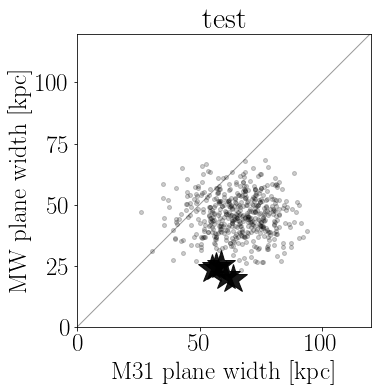

In [21]:
scatter_plot(M31_obs_vmag_sorted_full, MW_obs_vmag_sorted_full, 
             M31_obs_vmag_sorted_full, MW_obs_vmag_sorted_full, 
             field='width', title='test', 
             label_obs='Obs.', label_sim='Obs.  + Rand.',
             put_legend=False,
             random=True)

type ranked, field width, KS Ks_2sampResult(statistic=1.0, pvalue=0.0037813540593701006)


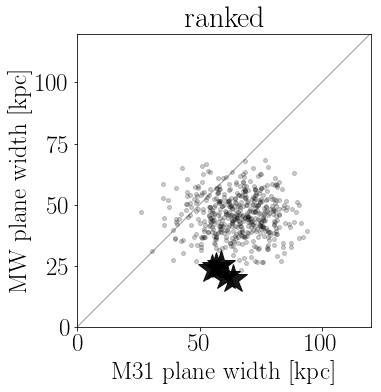

In [22]:
scatter_plot(M31_obs_vmag_sorted_full, MW_obs_vmag_sorted_full, 
             M31_obs_vmag_sorted_full, MW_obs_vmag_sorted_full, 
             field='width', title='ranked', 
             label_obs='Obs.', label_sim='Obs.  + Rand.',
             put_legend=False,
             random=True)

type ranked, field mu, KS Ks_2sampResult(statistic=1.0, pvalue=0.0037813540593701006)


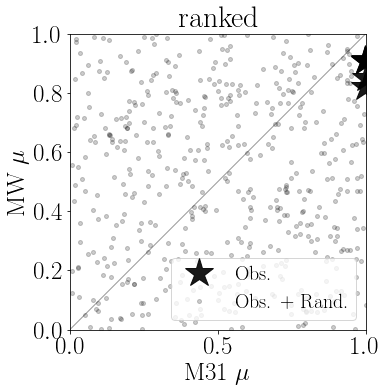

In [23]:
scatter_plot(M31_obs_vmag_sorted_full, MW_obs_vmag_sorted_full, 
             M31_obs_vmag_sorted_full, MW_obs_vmag_sorted_full, 
             field='mu', title='ranked', 
             label_obs='Obs.', label_sim='Obs.  + Rand.',
             put_legend=True,
             random=True)

type ranked, field ca_ratio, KS Ks_2sampResult(statistic=1.0, pvalue=0.0037813540593701006)


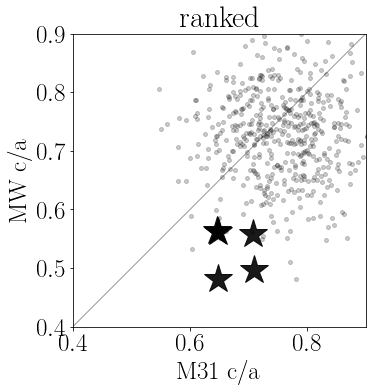

In [24]:
scatter_plot(M31_obs_vmag_sorted_full, MW_obs_vmag_sorted_full, 
             M31_obs_vmag_sorted_full, MW_obs_vmag_sorted_full, 
             field='ca_ratio', title='ranked', 
             label_obs='Obs.', label_sim='Obs.  + Rand.',
             put_legend=False,
             random=True)

type ranked, field ba_ratio, KS Ks_2sampResult(statistic=0.59999999999999998, pvalue=0.20898483057516717)


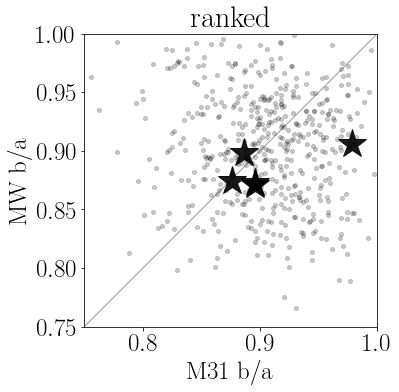

In [25]:
scatter_plot(M31_obs_vmag_sorted_full, MW_obs_vmag_sorted_full, 
             M31_obs_vmag_sorted_full, MW_obs_vmag_sorted_full, 
             field='ba_ratio', title='ranked', 
             label_obs='Obs.', label_sim='Obs.  + Rand.',
             put_legend=False,
             random=True)

type ranked, field width, KS Ks_2sampResult(statistic=0.20000000000000001, pvalue=0.77095294467658682)


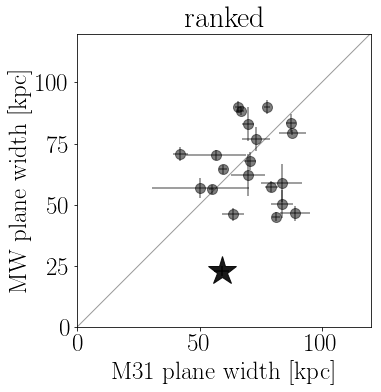

In [26]:
scatter_plot(M31_obs_vmag_sorted, MW_obs_vmag_sorted, 
             M31_sim_vmax_sorted, MW_sim_vmax_sorted, 
             put_legend=False,
             field='width', title='ranked')

type ranked, field mu, KS Ks_2sampResult(statistic=0.29999999999999999, pvalue=0.27526886726742134)


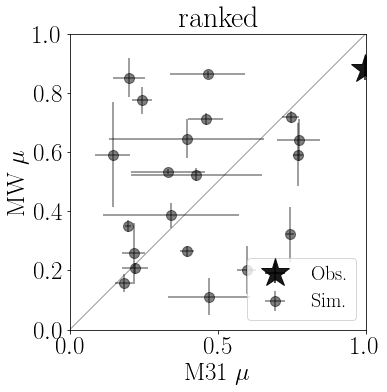

In [27]:
scatter_plot(M31_obs_vmag_sorted, MW_obs_vmag_sorted, 
             M31_sim_vmax_sorted, MW_sim_vmax_sorted, 
             put_legend=True,
             field='mu', title='ranked')

type ranked, field ca_ratio, KS Ks_2sampResult(statistic=0.20000000000000001, pvalue=0.77095294467658682)


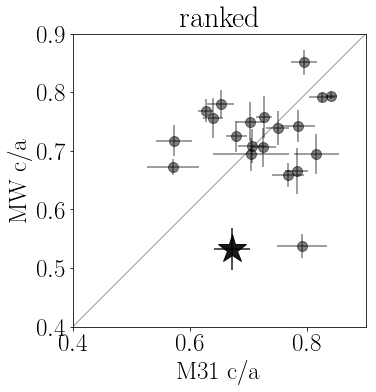

In [28]:
scatter_plot(M31_obs_vmag_sorted, MW_obs_vmag_sorted, 
             M31_sim_vmax_sorted, MW_sim_vmax_sorted, 
             put_legend=False,
             field='ca_ratio', title='ranked')

type ranked, field ba_ratio, KS Ks_2sampResult(statistic=0.15000000000000002, pvalue=0.96548474089861591)


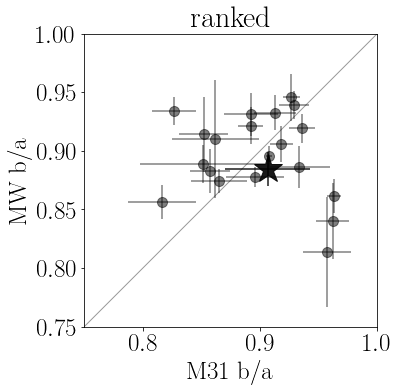

In [29]:
scatter_plot(M31_obs_vmag_sorted, MW_obs_vmag_sorted, 
             M31_sim_vmax_sorted, MW_sim_vmax_sorted, 
             put_legend=False,
             field='ba_ratio', title='ranked')

KS2 field mu, KS Ks_2sampResult(statistic=0.29999999999999999, pvalue=0.27526886726742134)
M31 KS uniform field mu, KS KstestResult(statistic=0.75, pvalue=3.7636560534792807e-12)
M31 KS normal field mu, KS KstestResult(statistic=0.27343823572947473, pvalue=0.082062427361510037)
MW KS uniform field mu, KS KstestResult(statistic=0.45000000000000001, pvalue=0.00032446411409559062)
MW KS normal field mu, KS KstestResult(statistic=0.11605491675237889, pvalue=0.95046623875257175)


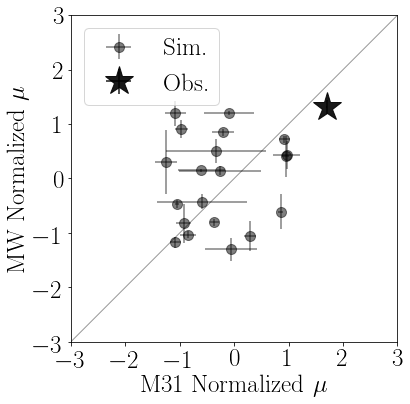

In [30]:
plot_normalized(field='mu')

KS2 field ca_ratio, KS Ks_2sampResult(statistic=0.25, pvalue=0.4973423353136131)
M31 KS uniform field ca_ratio, KS KstestResult(statistic=0.59999999999999998, pvalue=2.048301164236932e-07)
M31 KS normal field ca_ratio, KS KstestResult(statistic=0.20881994946510518, pvalue=0.30457079038582768)
MW KS uniform field ca_ratio, KS KstestResult(statistic=0.73309659074836475, pvalue=1.6444845485352744e-11)
MW KS normal field ca_ratio, KS KstestResult(statistic=0.28360837452652621, pvalue=0.064589521183232579)


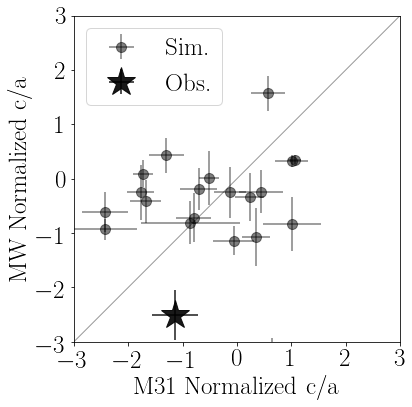

In [31]:
plot_normalized(field='ca_ratio')

KS2 field ba_ratio, KS Ks_2sampResult(statistic=0.19999999999999998, pvalue=0.77095294467658682)
M31 KS uniform field ba_ratio, KS KstestResult(statistic=0.55000000000000004, pvalue=3.2861970662434459e-06)
M31 KS normal field ba_ratio, KS KstestResult(statistic=0.17699483134928551, pvalue=0.51007464646654621)
MW KS uniform field ba_ratio, KS KstestResult(statistic=0.55000000000000004, pvalue=3.2861970662434459e-06)
MW KS normal field ba_ratio, KS KstestResult(statistic=0.18396419864319336, pvalue=0.45890023291278559)


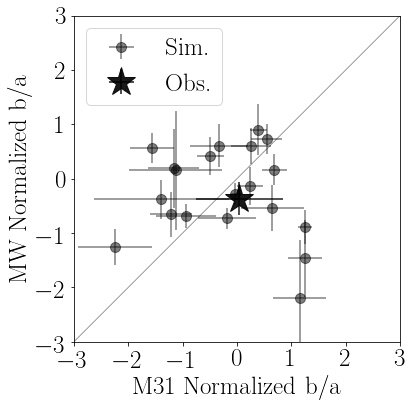

In [32]:
plot_normalized(field='ba_ratio')

KS2 field width, KS Ks_2sampResult(statistic=0.20000000000000001, pvalue=0.77095294467658682)
M31 KS uniform field width, KS KstestResult(statistic=0.65000000000000002, pvalue=8.7500484635683051e-09)
M31 KS normal field width, KS KstestResult(statistic=0.23365907596617141, pvalue=0.19194113222035525)
MW KS uniform field width, KS KstestResult(statistic=0.50505507267147132, pvalue=2.999815474735712e-05)
MW KS normal field width, KS KstestResult(statistic=0.18147836859735389, pvalue=0.47675153753799648)


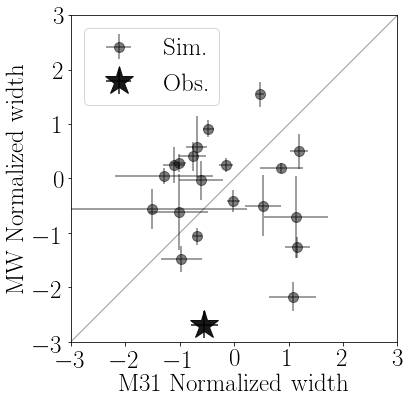

In [33]:
plot_normalized(field='width')